# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


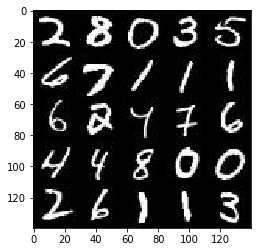

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

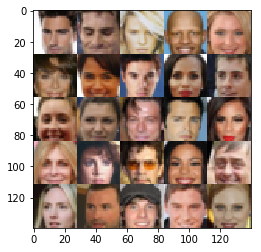

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorFlow Version: 1.7.0
Default GPU Device: /device:GPU:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr_rate = tf.placeholder(tf.float32, name='lr_rate')
    

    return input_real, input_z, lr_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x = tf.layers.conv2d(images, 32, 5, strides=2, padding='same')
        x = tf.maximum(x*alpha, x)
        
        x = tf.nn.dropout(x, 0.8)
        
        x = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x*alpha, x)
        
        x = tf.nn.dropout(x, 0.8)
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x*alpha, x)
        
        x = tf.nn.dropout(x, 0.8)
        
        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x*alpha, x)
        
        x = tf.reshape(x, (-1, 2*2*256))
        x = tf.layers.dense(x, 1, activation=None)
        out = tf.sigmoid(x);
        return out, x


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse=not is_train):
        x = tf.layers.dense(z, 2*2*512)
        x = tf.reshape(x, (-1, 2, 2, 512))
        
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x*alpha, x)
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides=2, padding='valid')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x*alpha, x)
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x*alpha, x)
        
#         x = tf.layers.conv2d_transpose(x, 64, 5, strides=1, padding='same')
#         x = tf.layers.batch_normalization(x, training=is_train)
#         x = tf.maximum(x*alpha, x)
        
        x = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=2, padding='same')
        out = tf.tanh(x)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    count, width, height, channels = data_shape
    input_real, input_z, lr_rate = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr_rate, beta1)
    
    count = 0;
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                count += 1
                batch_images = batch_images * 2
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, lr_rate: learning_rate})
                
                if count % 10 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if count % 100 == 0:
                    show_generator_output(sess, 25, input_z, channels, data_image_mode)
        
        show_generator_output(sess, 25, input_z, channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.8488... Generator Loss: 3.7615
Epoch 1/2... Discriminator Loss: 1.5047... Generator Loss: 1.7026
Epoch 1/2... Discriminator Loss: 1.4994... Generator Loss: 1.3209
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 1.6552
Epoch 1/2... Discriminator Loss: 1.1105... Generator Loss: 0.8934
Epoch 1/2... Discriminator Loss: 2.4186... Generator Loss: 0.1125
Epoch 1/2... Discriminator Loss: 1.4245... Generator Loss: 0.5015
Epoch 1/2... Discriminator Loss: 0.7919... Generator Loss: 1.7999
Epoch 1/2... Discriminator Loss: 1.5844... Generator Loss: 2.0986
Epoch 1/2... Discriminator Loss: 1.3219... Generator Loss: 0.5773


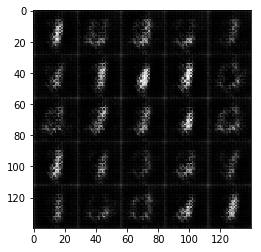

Epoch 1/2... Discriminator Loss: 1.3441... Generator Loss: 0.6362
Epoch 1/2... Discriminator Loss: 1.2885... Generator Loss: 1.1122
Epoch 1/2... Discriminator Loss: 1.5281... Generator Loss: 0.9148
Epoch 1/2... Discriminator Loss: 1.7039... Generator Loss: 0.7565
Epoch 1/2... Discriminator Loss: 1.3817... Generator Loss: 0.5249
Epoch 1/2... Discriminator Loss: 1.4554... Generator Loss: 1.0319
Epoch 1/2... Discriminator Loss: 1.3626... Generator Loss: 0.6570
Epoch 1/2... Discriminator Loss: 1.4386... Generator Loss: 0.7763
Epoch 1/2... Discriminator Loss: 1.2116... Generator Loss: 0.7194
Epoch 1/2... Discriminator Loss: 1.5796... Generator Loss: 0.3086


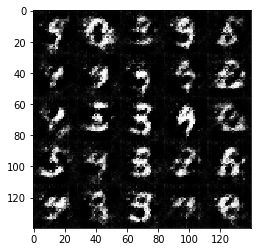

Epoch 1/2... Discriminator Loss: 1.2454... Generator Loss: 0.6998
Epoch 1/2... Discriminator Loss: 1.3477... Generator Loss: 0.5807
Epoch 1/2... Discriminator Loss: 1.3579... Generator Loss: 0.7291
Epoch 1/2... Discriminator Loss: 1.3475... Generator Loss: 0.5826
Epoch 1/2... Discriminator Loss: 1.6001... Generator Loss: 0.3782
Epoch 1/2... Discriminator Loss: 1.4627... Generator Loss: 0.7515
Epoch 1/2... Discriminator Loss: 1.4318... Generator Loss: 0.7055
Epoch 1/2... Discriminator Loss: 1.4274... Generator Loss: 0.5755
Epoch 1/2... Discriminator Loss: 1.3207... Generator Loss: 0.5490
Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 0.4830


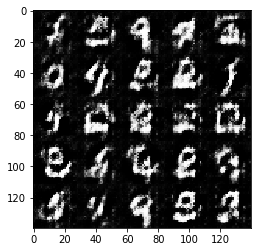

Epoch 1/2... Discriminator Loss: 1.1943... Generator Loss: 0.6236
Epoch 1/2... Discriminator Loss: 1.3333... Generator Loss: 0.6973
Epoch 1/2... Discriminator Loss: 1.4347... Generator Loss: 0.5103
Epoch 1/2... Discriminator Loss: 1.2595... Generator Loss: 0.6676
Epoch 1/2... Discriminator Loss: 1.6178... Generator Loss: 0.3125
Epoch 1/2... Discriminator Loss: 1.3253... Generator Loss: 0.4952
Epoch 1/2... Discriminator Loss: 1.2318... Generator Loss: 0.8381
Epoch 1/2... Discriminator Loss: 1.3010... Generator Loss: 0.8048
Epoch 1/2... Discriminator Loss: 1.2902... Generator Loss: 0.7350
Epoch 1/2... Discriminator Loss: 1.2463... Generator Loss: 0.6247


Epoch 1/2... Discriminator Loss: 1.3563... Generator Loss: 0.9426
Epoch 1/2... Discriminator Loss: 1.1507... Generator Loss: 0.8452
Epoch 1/2... Discriminator Loss: 1.2585... Generator Loss: 0.8290
Epoch 1/2... Discriminator Loss: 1.3725... Generator Loss: 0.9051
Epoch 1/2... Discriminator Loss: 1.3065... Generator Loss: 0.7744
Epoch 1/2... Discriminator Loss: 1.2835... Generator Loss: 0.6493
Epoch 1/2... Discriminator Loss: 1.3333... Generator Loss: 0.4820
Epoch 1/2... Discriminator Loss: 1.2756... Generator Loss: 0.6144
Epoch 1/2... Discriminator Loss: 1.2489... Generator Loss: 0.6131
Epoch 1/2... Discriminator Loss: 1.4138... Generator Loss: 0.3846


Epoch 1/2... Discriminator Loss: 1.2591... Generator Loss: 0.5426
Epoch 1/2... Discriminator Loss: 1.4936... Generator Loss: 0.3823
Epoch 1/2... Discriminator Loss: 1.3351... Generator Loss: 0.8391
Epoch 1/2... Discriminator Loss: 1.3331... Generator Loss: 0.6348
Epoch 1/2... Discriminator Loss: 1.4536... Generator Loss: 0.5006
Epoch 1/2... Discriminator Loss: 1.4306... Generator Loss: 0.4604
Epoch 1/2... Discriminator Loss: 1.3109... Generator Loss: 0.8409
Epoch 1/2... Discriminator Loss: 1.1469... Generator Loss: 0.8237
Epoch 1/2... Discriminator Loss: 1.3361... Generator Loss: 0.5402
Epoch 1/2... Discriminator Loss: 1.5648... Generator Loss: 0.3193


Epoch 1/2... Discriminator Loss: 1.3166... Generator Loss: 0.5089
Epoch 1/2... Discriminator Loss: 1.5879... Generator Loss: 0.3649
Epoch 1/2... Discriminator Loss: 1.4577... Generator Loss: 0.4635
Epoch 1/2... Discriminator Loss: 1.3893... Generator Loss: 0.4762
Epoch 1/2... Discriminator Loss: 1.2569... Generator Loss: 0.5272
Epoch 1/2... Discriminator Loss: 1.3780... Generator Loss: 0.4594
Epoch 1/2... Discriminator Loss: 1.2646... Generator Loss: 0.4799
Epoch 1/2... Discriminator Loss: 1.3686... Generator Loss: 0.5583
Epoch 1/2... Discriminator Loss: 1.3162... Generator Loss: 0.6931
Epoch 1/2... Discriminator Loss: 1.5388... Generator Loss: 0.3831


Epoch 1/2... Discriminator Loss: 1.3085... Generator Loss: 0.6310
Epoch 1/2... Discriminator Loss: 1.2019... Generator Loss: 0.5746
Epoch 1/2... Discriminator Loss: 1.1762... Generator Loss: 1.0302
Epoch 1/2... Discriminator Loss: 1.5332... Generator Loss: 0.5071
Epoch 1/2... Discriminator Loss: 1.0700... Generator Loss: 0.7028
Epoch 1/2... Discriminator Loss: 1.0325... Generator Loss: 0.6979
Epoch 1/2... Discriminator Loss: 1.2304... Generator Loss: 0.5050
Epoch 1/2... Discriminator Loss: 1.5005... Generator Loss: 0.3850
Epoch 1/2... Discriminator Loss: 1.3013... Generator Loss: 0.3838
Epoch 1/2... Discriminator Loss: 1.1348... Generator Loss: 0.7280


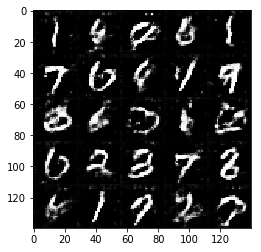

Epoch 1/2... Discriminator Loss: 0.9820... Generator Loss: 1.0895
Epoch 1/2... Discriminator Loss: 1.2133... Generator Loss: 0.8506
Epoch 1/2... Discriminator Loss: 1.3936... Generator Loss: 0.4884
Epoch 1/2... Discriminator Loss: 1.3217... Generator Loss: 0.4150
Epoch 1/2... Discriminator Loss: 1.1868... Generator Loss: 0.6507
Epoch 1/2... Discriminator Loss: 1.1376... Generator Loss: 0.9214
Epoch 1/2... Discriminator Loss: 1.2925... Generator Loss: 0.6428
Epoch 1/2... Discriminator Loss: 1.4269... Generator Loss: 0.4658
Epoch 1/2... Discriminator Loss: 1.0986... Generator Loss: 0.6119
Epoch 1/2... Discriminator Loss: 1.0852... Generator Loss: 1.0846


Epoch 1/2... Discriminator Loss: 1.5312... Generator Loss: 0.3076
Epoch 1/2... Discriminator Loss: 1.2233... Generator Loss: 0.6351
Epoch 1/2... Discriminator Loss: 1.4229... Generator Loss: 1.3293
Epoch 1/2... Discriminator Loss: 1.0300... Generator Loss: 0.9469
Epoch 1/2... Discriminator Loss: 1.1511... Generator Loss: 1.1743
Epoch 1/2... Discriminator Loss: 1.2337... Generator Loss: 0.5464
Epoch 1/2... Discriminator Loss: 0.9358... Generator Loss: 0.8935
Epoch 1/2... Discriminator Loss: 1.5647... Generator Loss: 0.3923
Epoch 1/2... Discriminator Loss: 1.4574... Generator Loss: 0.3645
Epoch 1/2... Discriminator Loss: 1.1281... Generator Loss: 1.0745


Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 0.5664
Epoch 1/2... Discriminator Loss: 1.3407... Generator Loss: 0.5755
Epoch 1/2... Discriminator Loss: 0.9284... Generator Loss: 0.9448
Epoch 1/2... Discriminator Loss: 1.1444... Generator Loss: 1.0147
Epoch 1/2... Discriminator Loss: 1.0215... Generator Loss: 0.6978
Epoch 1/2... Discriminator Loss: 1.3379... Generator Loss: 0.4861
Epoch 1/2... Discriminator Loss: 0.9739... Generator Loss: 0.9474
Epoch 1/2... Discriminator Loss: 0.9238... Generator Loss: 0.7440
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 1.0261
Epoch 1/2... Discriminator Loss: 1.3635... Generator Loss: 0.4947


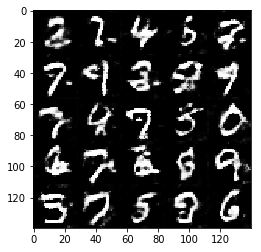

Epoch 1/2... Discriminator Loss: 1.4769... Generator Loss: 0.4407
Epoch 1/2... Discriminator Loss: 1.4816... Generator Loss: 0.4273
Epoch 1/2... Discriminator Loss: 1.4222... Generator Loss: 0.4216
Epoch 1/2... Discriminator Loss: 1.0140... Generator Loss: 0.5047
Epoch 1/2... Discriminator Loss: 1.2112... Generator Loss: 0.6677
Epoch 1/2... Discriminator Loss: 1.1905... Generator Loss: 0.5366
Epoch 1/2... Discriminator Loss: 0.9994... Generator Loss: 0.8612
Epoch 1/2... Discriminator Loss: 0.7196... Generator Loss: 1.2138
Epoch 1/2... Discriminator Loss: 1.1022... Generator Loss: 1.3811
Epoch 1/2... Discriminator Loss: 1.3122... Generator Loss: 0.3642


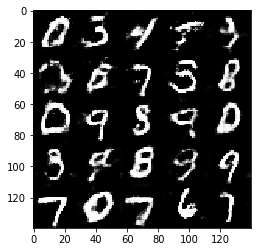

Epoch 1/2... Discriminator Loss: 0.9131... Generator Loss: 1.0331
Epoch 1/2... Discriminator Loss: 1.1343... Generator Loss: 0.4804
Epoch 1/2... Discriminator Loss: 1.3651... Generator Loss: 0.7263
Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 0.7433
Epoch 1/2... Discriminator Loss: 1.4141... Generator Loss: 0.4717
Epoch 1/2... Discriminator Loss: 1.5826... Generator Loss: 0.4531
Epoch 1/2... Discriminator Loss: 0.8709... Generator Loss: 1.3227
Epoch 1/2... Discriminator Loss: 0.8256... Generator Loss: 1.7305
Epoch 1/2... Discriminator Loss: 0.6028... Generator Loss: 1.2145
Epoch 1/2... Discriminator Loss: 1.1041... Generator Loss: 0.6180


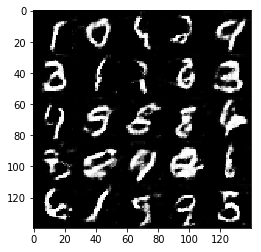

Epoch 1/2... Discriminator Loss: 1.3590... Generator Loss: 0.3944
Epoch 1/2... Discriminator Loss: 1.3412... Generator Loss: 1.4882
Epoch 1/2... Discriminator Loss: 0.9211... Generator Loss: 0.7218
Epoch 1/2... Discriminator Loss: 0.8968... Generator Loss: 0.9031
Epoch 1/2... Discriminator Loss: 1.0066... Generator Loss: 2.2629
Epoch 1/2... Discriminator Loss: 1.5588... Generator Loss: 0.3797
Epoch 1/2... Discriminator Loss: 0.8692... Generator Loss: 0.9695
Epoch 1/2... Discriminator Loss: 1.0549... Generator Loss: 0.7916
Epoch 1/2... Discriminator Loss: 1.9266... Generator Loss: 0.2424
Epoch 1/2... Discriminator Loss: 1.0059... Generator Loss: 0.4151


Epoch 1/2... Discriminator Loss: 0.8583... Generator Loss: 1.0321
Epoch 1/2... Discriminator Loss: 0.8890... Generator Loss: 1.0891
Epoch 1/2... Discriminator Loss: 1.0903... Generator Loss: 0.6768
Epoch 1/2... Discriminator Loss: 1.2192... Generator Loss: 0.3674
Epoch 1/2... Discriminator Loss: 0.9999... Generator Loss: 1.7846
Epoch 1/2... Discriminator Loss: 1.0252... Generator Loss: 1.0446
Epoch 1/2... Discriminator Loss: 0.8571... Generator Loss: 0.7014
Epoch 1/2... Discriminator Loss: 1.0595... Generator Loss: 0.5984
Epoch 1/2... Discriminator Loss: 0.9410... Generator Loss: 1.7444
Epoch 1/2... Discriminator Loss: 1.3258... Generator Loss: 0.6142


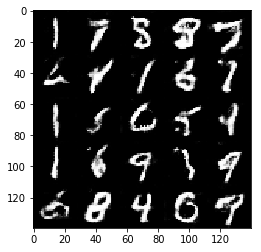

Epoch 1/2... Discriminator Loss: 0.8112... Generator Loss: 0.8102
Epoch 1/2... Discriminator Loss: 0.9242... Generator Loss: 0.6132
Epoch 1/2... Discriminator Loss: 1.0076... Generator Loss: 1.3364
Epoch 1/2... Discriminator Loss: 1.1073... Generator Loss: 0.5918
Epoch 1/2... Discriminator Loss: 0.7043... Generator Loss: 1.5296
Epoch 1/2... Discriminator Loss: 0.7717... Generator Loss: 1.0046
Epoch 1/2... Discriminator Loss: 0.6449... Generator Loss: 1.4330
Epoch 1/2... Discriminator Loss: 1.0055... Generator Loss: 0.5534
Epoch 1/2... Discriminator Loss: 0.8994... Generator Loss: 1.0268
Epoch 1/2... Discriminator Loss: 0.9418... Generator Loss: 0.8872


Epoch 1/2... Discriminator Loss: 0.5933... Generator Loss: 1.7338
Epoch 1/2... Discriminator Loss: 1.2947... Generator Loss: 0.4948
Epoch 1/2... Discriminator Loss: 0.9163... Generator Loss: 1.2267
Epoch 1/2... Discriminator Loss: 0.7636... Generator Loss: 1.4656
Epoch 1/2... Discriminator Loss: 0.9466... Generator Loss: 0.8072
Epoch 1/2... Discriminator Loss: 1.0596... Generator Loss: 0.7675
Epoch 1/2... Discriminator Loss: 0.9350... Generator Loss: 1.8632
Epoch 1/2... Discriminator Loss: 0.9645... Generator Loss: 0.7618
Epoch 1/2... Discriminator Loss: 0.8995... Generator Loss: 0.9345
Epoch 1/2... Discriminator Loss: 0.7132... Generator Loss: 1.2263


Epoch 1/2... Discriminator Loss: 0.9045... Generator Loss: 1.1662
Epoch 1/2... Discriminator Loss: 1.6289... Generator Loss: 0.3348
Epoch 1/2... Discriminator Loss: 0.6683... Generator Loss: 1.5205
Epoch 1/2... Discriminator Loss: 0.8303... Generator Loss: 1.0894
Epoch 1/2... Discriminator Loss: 0.8464... Generator Loss: 1.1719
Epoch 1/2... Discriminator Loss: 0.5132... Generator Loss: 1.4603
Epoch 1/2... Discriminator Loss: 0.5968... Generator Loss: 1.3881
Epoch 1/2... Discriminator Loss: 0.7917... Generator Loss: 0.8643
Epoch 1/2... Discriminator Loss: 0.7245... Generator Loss: 1.3060
Epoch 1/2... Discriminator Loss: 1.0461... Generator Loss: 2.7600


Epoch 1/2... Discriminator Loss: 0.6269... Generator Loss: 1.0107
Epoch 1/2... Discriminator Loss: 1.0008... Generator Loss: 0.6577
Epoch 1/2... Discriminator Loss: 1.9697... Generator Loss: 0.1799
Epoch 1/2... Discriminator Loss: 0.8877... Generator Loss: 1.3415
Epoch 1/2... Discriminator Loss: 0.9200... Generator Loss: 0.9152
Epoch 1/2... Discriminator Loss: 0.9306... Generator Loss: 1.7811
Epoch 1/2... Discriminator Loss: 0.6267... Generator Loss: 1.4820
Epoch 2/2... Discriminator Loss: 0.7833... Generator Loss: 1.8430
Epoch 2/2... Discriminator Loss: 1.9218... Generator Loss: 0.3823
Epoch 2/2... Discriminator Loss: 0.7215... Generator Loss: 1.7539


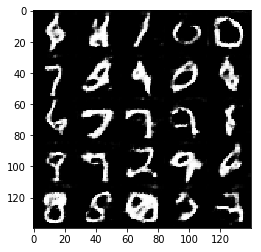

Epoch 2/2... Discriminator Loss: 1.0048... Generator Loss: 0.9631
Epoch 2/2... Discriminator Loss: 1.0187... Generator Loss: 1.3256
Epoch 2/2... Discriminator Loss: 0.8016... Generator Loss: 1.9779
Epoch 2/2... Discriminator Loss: 1.3498... Generator Loss: 0.2320
Epoch 2/2... Discriminator Loss: 1.1020... Generator Loss: 0.4995
Epoch 2/2... Discriminator Loss: 1.0468... Generator Loss: 1.8316
Epoch 2/2... Discriminator Loss: 1.3089... Generator Loss: 0.7731
Epoch 2/2... Discriminator Loss: 0.7725... Generator Loss: 0.8934
Epoch 2/2... Discriminator Loss: 0.7005... Generator Loss: 1.5762
Epoch 2/2... Discriminator Loss: 1.7685... Generator Loss: 0.4348


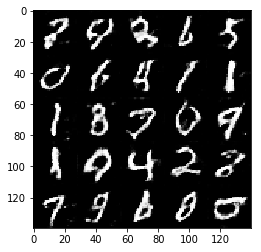

Epoch 2/2... Discriminator Loss: 1.3862... Generator Loss: 0.3232
Epoch 2/2... Discriminator Loss: 1.2462... Generator Loss: 3.3302
Epoch 2/2... Discriminator Loss: 1.0069... Generator Loss: 2.3531
Epoch 2/2... Discriminator Loss: 0.9416... Generator Loss: 1.5642
Epoch 2/2... Discriminator Loss: 0.9763... Generator Loss: 0.5950
Epoch 2/2... Discriminator Loss: 0.8818... Generator Loss: 1.5701
Epoch 2/2... Discriminator Loss: 0.6174... Generator Loss: 0.6854
Epoch 2/2... Discriminator Loss: 0.6265... Generator Loss: 1.4286
Epoch 2/2... Discriminator Loss: 2.1296... Generator Loss: 0.1947
Epoch 2/2... Discriminator Loss: 1.5073... Generator Loss: 0.4487


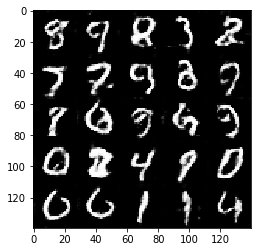

Epoch 2/2... Discriminator Loss: 1.1902... Generator Loss: 0.4208
Epoch 2/2... Discriminator Loss: 1.7742... Generator Loss: 0.1713
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.8047
Epoch 2/2... Discriminator Loss: 1.2399... Generator Loss: 0.3307
Epoch 2/2... Discriminator Loss: 0.9620... Generator Loss: 2.5771
Epoch 2/2... Discriminator Loss: 0.6264... Generator Loss: 1.4304
Epoch 2/2... Discriminator Loss: 0.5050... Generator Loss: 1.6320
Epoch 2/2... Discriminator Loss: 0.4154... Generator Loss: 1.1986
Epoch 2/2... Discriminator Loss: 0.5090... Generator Loss: 1.9229
Epoch 2/2... Discriminator Loss: 0.5925... Generator Loss: 0.8891


Epoch 2/2... Discriminator Loss: 1.3467... Generator Loss: 0.5684
Epoch 2/2... Discriminator Loss: 0.9816... Generator Loss: 0.3712
Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 2.2063
Epoch 2/2... Discriminator Loss: 1.3058... Generator Loss: 0.5015
Epoch 2/2... Discriminator Loss: 0.8567... Generator Loss: 0.6895
Epoch 2/2... Discriminator Loss: 0.6521... Generator Loss: 0.9860
Epoch 2/2... Discriminator Loss: 1.1623... Generator Loss: 1.1133
Epoch 2/2... Discriminator Loss: 1.4273... Generator Loss: 0.7528
Epoch 2/2... Discriminator Loss: 1.8001... Generator Loss: 0.2455
Epoch 2/2... Discriminator Loss: 0.7935... Generator Loss: 1.3920


Epoch 2/2... Discriminator Loss: 1.1871... Generator Loss: 1.1290
Epoch 2/2... Discriminator Loss: 0.6856... Generator Loss: 1.1952
Epoch 2/2... Discriminator Loss: 0.8378... Generator Loss: 1.5708
Epoch 2/2... Discriminator Loss: 0.7816... Generator Loss: 2.5719
Epoch 2/2... Discriminator Loss: 0.6354... Generator Loss: 1.3643
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 2.6946
Epoch 2/2... Discriminator Loss: 1.1958... Generator Loss: 2.1184
Epoch 2/2... Discriminator Loss: 1.1241... Generator Loss: 0.7930
Epoch 2/2... Discriminator Loss: 0.8683... Generator Loss: 1.2562
Epoch 2/2... Discriminator Loss: 1.1630... Generator Loss: 0.6636


Epoch 2/2... Discriminator Loss: 0.8531... Generator Loss: 0.5854
Epoch 2/2... Discriminator Loss: 1.5956... Generator Loss: 1.7823
Epoch 2/2... Discriminator Loss: 0.6400... Generator Loss: 2.8861
Epoch 2/2... Discriminator Loss: 2.0798... Generator Loss: 0.1971
Epoch 2/2... Discriminator Loss: 1.0143... Generator Loss: 0.5882
Epoch 2/2... Discriminator Loss: 0.8953... Generator Loss: 1.2119
Epoch 2/2... Discriminator Loss: 1.4060... Generator Loss: 2.8179
Epoch 2/2... Discriminator Loss: 0.4684... Generator Loss: 0.6793
Epoch 2/2... Discriminator Loss: 1.1287... Generator Loss: 2.4446
Epoch 2/2... Discriminator Loss: 1.5098... Generator Loss: 0.3883


Epoch 2/2... Discriminator Loss: 0.6484... Generator Loss: 1.1248
Epoch 2/2... Discriminator Loss: 1.0485... Generator Loss: 0.7050
Epoch 2/2... Discriminator Loss: 1.0366... Generator Loss: 0.5005
Epoch 2/2... Discriminator Loss: 1.0304... Generator Loss: 0.4637
Epoch 2/2... Discriminator Loss: 1.4914... Generator Loss: 0.5072
Epoch 2/2... Discriminator Loss: 0.8259... Generator Loss: 0.5195
Epoch 2/2... Discriminator Loss: 1.5754... Generator Loss: 0.5697
Epoch 2/2... Discriminator Loss: 0.9558... Generator Loss: 0.6623
Epoch 2/2... Discriminator Loss: 0.8823... Generator Loss: 1.4169
Epoch 2/2... Discriminator Loss: 1.9990... Generator Loss: 0.1912


Epoch 2/2... Discriminator Loss: 1.1605... Generator Loss: 0.3528
Epoch 2/2... Discriminator Loss: 0.6444... Generator Loss: 0.5513
Epoch 2/2... Discriminator Loss: 0.5580... Generator Loss: 1.4225
Epoch 2/2... Discriminator Loss: 0.8227... Generator Loss: 0.9269
Epoch 2/2... Discriminator Loss: 0.7638... Generator Loss: 0.8739
Epoch 2/2... Discriminator Loss: 0.9839... Generator Loss: 0.6954
Epoch 2/2... Discriminator Loss: 1.5114... Generator Loss: 2.6056
Epoch 2/2... Discriminator Loss: 1.0625... Generator Loss: 0.7523
Epoch 2/2... Discriminator Loss: 0.7626... Generator Loss: 1.1062
Epoch 2/2... Discriminator Loss: 1.0118... Generator Loss: 0.9801


Epoch 2/2... Discriminator Loss: 0.7474... Generator Loss: 0.6823
Epoch 2/2... Discriminator Loss: 1.1705... Generator Loss: 2.4075
Epoch 2/2... Discriminator Loss: 0.9066... Generator Loss: 0.8752
Epoch 2/2... Discriminator Loss: 0.7979... Generator Loss: 0.7240
Epoch 2/2... Discriminator Loss: 1.3214... Generator Loss: 0.3192
Epoch 2/2... Discriminator Loss: 2.1066... Generator Loss: 0.1558
Epoch 2/2... Discriminator Loss: 1.6622... Generator Loss: 0.2858
Epoch 2/2... Discriminator Loss: 1.0383... Generator Loss: 2.4869
Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 2.8369
Epoch 2/2... Discriminator Loss: 1.1757... Generator Loss: 2.3731


Epoch 2/2... Discriminator Loss: 0.7448... Generator Loss: 0.5210
Epoch 2/2... Discriminator Loss: 0.8205... Generator Loss: 0.7922
Epoch 2/2... Discriminator Loss: 0.5707... Generator Loss: 1.0993
Epoch 2/2... Discriminator Loss: 1.3477... Generator Loss: 0.5255
Epoch 2/2... Discriminator Loss: 1.2586... Generator Loss: 2.1457
Epoch 2/2... Discriminator Loss: 1.3095... Generator Loss: 0.5298
Epoch 2/2... Discriminator Loss: 1.0940... Generator Loss: 0.8531
Epoch 2/2... Discriminator Loss: 0.8152... Generator Loss: 1.9037
Epoch 2/2... Discriminator Loss: 0.6458... Generator Loss: 0.6999
Epoch 2/2... Discriminator Loss: 0.4784... Generator Loss: 1.6667


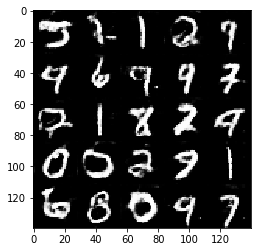

Epoch 2/2... Discriminator Loss: 1.0528... Generator Loss: 2.2638
Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 1.2343
Epoch 2/2... Discriminator Loss: 1.4090... Generator Loss: 0.6533
Epoch 2/2... Discriminator Loss: 0.7267... Generator Loss: 1.1870
Epoch 2/2... Discriminator Loss: 0.6972... Generator Loss: 0.8703
Epoch 2/2... Discriminator Loss: 0.5730... Generator Loss: 1.9355
Epoch 2/2... Discriminator Loss: 1.2785... Generator Loss: 0.8883
Epoch 2/2... Discriminator Loss: 1.4802... Generator Loss: 0.5209
Epoch 2/2... Discriminator Loss: 1.0879... Generator Loss: 1.1835
Epoch 2/2... Discriminator Loss: 0.5467... Generator Loss: 0.9708


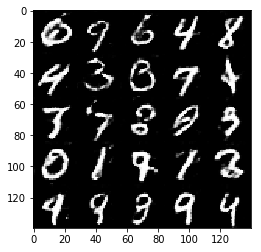

Epoch 2/2... Discriminator Loss: 0.5902... Generator Loss: 1.3911
Epoch 2/2... Discriminator Loss: 0.6623... Generator Loss: 2.3215
Epoch 2/2... Discriminator Loss: 0.3481... Generator Loss: 1.6676
Epoch 2/2... Discriminator Loss: 0.9289... Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 1.1083... Generator Loss: 0.6093
Epoch 2/2... Discriminator Loss: 2.1388... Generator Loss: 0.1956
Epoch 2/2... Discriminator Loss: 0.6680... Generator Loss: 0.7574
Epoch 2/2... Discriminator Loss: 0.9010... Generator Loss: 0.5317
Epoch 2/2... Discriminator Loss: 1.0691... Generator Loss: 0.5217
Epoch 2/2... Discriminator Loss: 0.6406... Generator Loss: 1.3712


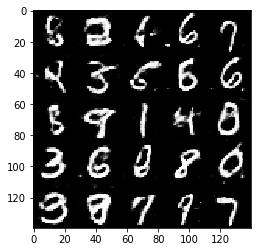

Epoch 2/2... Discriminator Loss: 0.8811... Generator Loss: 1.5540
Epoch 2/2... Discriminator Loss: 0.9275... Generator Loss: 0.6474
Epoch 2/2... Discriminator Loss: 2.3044... Generator Loss: 0.2899
Epoch 2/2... Discriminator Loss: 0.7795... Generator Loss: 0.8657
Epoch 2/2... Discriminator Loss: 1.1436... Generator Loss: 0.7127
Epoch 2/2... Discriminator Loss: 0.5974... Generator Loss: 1.3654
Epoch 2/2... Discriminator Loss: 0.6264... Generator Loss: 1.3741
Epoch 2/2... Discriminator Loss: 0.9666... Generator Loss: 0.8836
Epoch 2/2... Discriminator Loss: 0.6875... Generator Loss: 0.7285
Epoch 2/2... Discriminator Loss: 0.3963... Generator Loss: 1.7507


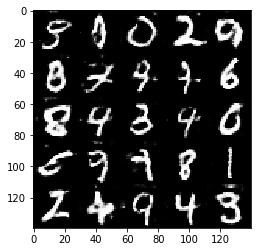

Epoch 2/2... Discriminator Loss: 2.3606... Generator Loss: 0.2941
Epoch 2/2... Discriminator Loss: 1.1593... Generator Loss: 1.2339
Epoch 2/2... Discriminator Loss: 0.6160... Generator Loss: 1.4169
Epoch 2/2... Discriminator Loss: 1.1507... Generator Loss: 0.4404
Epoch 2/2... Discriminator Loss: 0.6542... Generator Loss: 1.7413
Epoch 2/2... Discriminator Loss: 1.1994... Generator Loss: 0.3785
Epoch 2/2... Discriminator Loss: 0.6998... Generator Loss: 2.0864
Epoch 2/2... Discriminator Loss: 0.9900... Generator Loss: 0.2364
Epoch 2/2... Discriminator Loss: 0.8175... Generator Loss: 0.6613
Epoch 2/2... Discriminator Loss: 0.3643... Generator Loss: 0.8023


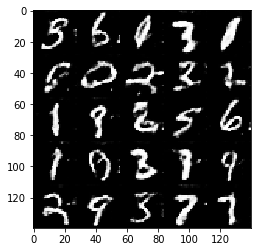

Epoch 2/2... Discriminator Loss: 0.6988... Generator Loss: 0.8492
Epoch 2/2... Discriminator Loss: 1.2389... Generator Loss: 0.2500
Epoch 2/2... Discriminator Loss: 0.8499... Generator Loss: 0.5096
Epoch 2/2... Discriminator Loss: 0.7442... Generator Loss: 0.8468
Epoch 2/2... Discriminator Loss: 1.3781... Generator Loss: 3.3761
Epoch 2/2... Discriminator Loss: 1.6779... Generator Loss: 0.2030
Epoch 2/2... Discriminator Loss: 0.3088... Generator Loss: 1.8880
Epoch 2/2... Discriminator Loss: 1.1724... Generator Loss: 0.7869
Epoch 2/2... Discriminator Loss: 0.4418... Generator Loss: 1.8519
Epoch 2/2... Discriminator Loss: 0.8490... Generator Loss: 1.0001


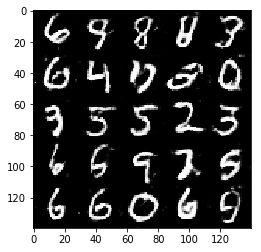

Epoch 2/2... Discriminator Loss: 0.4384... Generator Loss: 1.6985
Epoch 2/2... Discriminator Loss: 1.5751... Generator Loss: 0.5972
Epoch 2/2... Discriminator Loss: 0.5403... Generator Loss: 0.8972
Epoch 2/2... Discriminator Loss: 0.4643... Generator Loss: 1.0808
Epoch 2/2... Discriminator Loss: 0.6996... Generator Loss: 1.2319
Epoch 2/2... Discriminator Loss: 2.4390... Generator Loss: 0.1711
Epoch 2/2... Discriminator Loss: 0.7748... Generator Loss: 1.0295
Epoch 2/2... Discriminator Loss: 0.7656... Generator Loss: 2.0732
Epoch 2/2... Discriminator Loss: 0.4326... Generator Loss: 1.1652
Epoch 2/2... Discriminator Loss: 0.7133... Generator Loss: 1.3111


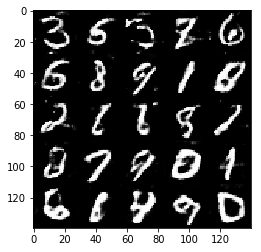

Epoch 2/2... Discriminator Loss: 2.4496... Generator Loss: 0.1653
Epoch 2/2... Discriminator Loss: 0.5860... Generator Loss: 2.1473
Epoch 2/2... Discriminator Loss: 1.0918... Generator Loss: 0.7771
Epoch 2/2... Discriminator Loss: 0.4088... Generator Loss: 1.8883
Epoch 2/2... Discriminator Loss: 0.5273... Generator Loss: 1.2654
Epoch 2/2... Discriminator Loss: 0.9526... Generator Loss: 0.7658
Epoch 2/2... Discriminator Loss: 0.5248... Generator Loss: 1.3548
Epoch 2/2... Discriminator Loss: 1.7250... Generator Loss: 0.2079
Epoch 2/2... Discriminator Loss: 1.1726... Generator Loss: 0.6311
Epoch 2/2... Discriminator Loss: 0.7963... Generator Loss: 1.1559


Epoch 2/2... Discriminator Loss: 0.5971... Generator Loss: 1.3957
Epoch 2/2... Discriminator Loss: 1.1968... Generator Loss: 0.4068
Epoch 2/2... Discriminator Loss: 0.7059... Generator Loss: 0.9471
Epoch 2/2... Discriminator Loss: 0.9773... Generator Loss: 0.6423
Epoch 2/2... Discriminator Loss: 0.2751... Generator Loss: 1.6087
Epoch 2/2... Discriminator Loss: 1.5565... Generator Loss: 0.3826
Epoch 2/2... Discriminator Loss: 0.7627... Generator Loss: 1.1277
Epoch 2/2... Discriminator Loss: 0.7742... Generator Loss: 2.4226
Epoch 2/2... Discriminator Loss: 0.9804... Generator Loss: 0.6753
Epoch 2/2... Discriminator Loss: 0.5671... Generator Loss: 3.1827


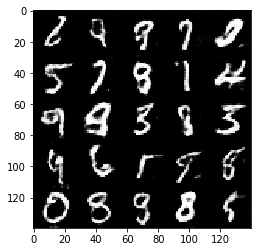

Epoch 2/2... Discriminator Loss: 1.2526... Generator Loss: 3.9270
Epoch 2/2... Discriminator Loss: 0.6653... Generator Loss: 1.5893
Epoch 2/2... Discriminator Loss: 1.9187... Generator Loss: 0.1931
Epoch 2/2... Discriminator Loss: 1.1796... Generator Loss: 0.8973
Epoch 2/2... Discriminator Loss: 0.4556... Generator Loss: 1.4692


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.9444... Generator Loss: 3.4115
Epoch 1/1... Discriminator Loss: 0.8975... Generator Loss: 1.6094
Epoch 1/1... Discriminator Loss: 2.0923... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.7567... Generator Loss: 0.3459
Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.5681
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.9285
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7407
Epoch 1/1... Discriminator Loss: 1.3356... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.5795


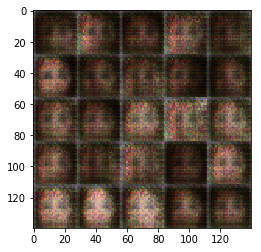

Epoch 1/1... Discriminator Loss: 1.5413... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.5403... Generator Loss: 0.4328
Epoch 1/1... Discriminator Loss: 1.7000... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.5903
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.5885
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.5628


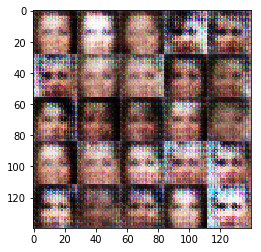

Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6325
Epoch 1/1... Discriminator Loss: 1.4830... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.5318
Epoch 1/1... Discriminator Loss: 1.5526... Generator Loss: 0.6027
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.6648


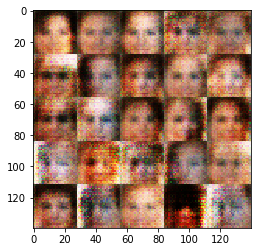

Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.5324
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.4245... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.2969... Generator Loss: 0.7433
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.6359
Epoch 1/1... Discriminator Loss: 1.4677... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.6566


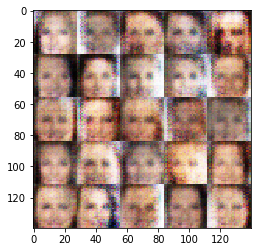

Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.3810... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.4570... Generator Loss: 0.6761
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.6915
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.6398


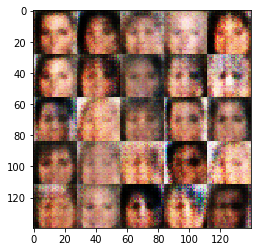

Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.3755... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.3781... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.4416... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.3621... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.3440... Generator Loss: 0.6890


Epoch 1/1... Discriminator Loss: 1.3445... Generator Loss: 0.6474
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4069... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.3939... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.7318


Epoch 1/1... Discriminator Loss: 1.3169... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3282... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6047
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.3895... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.5718


Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7072
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3040... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.6213
Epoch 1/1... Discriminator Loss: 1.3803... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6223
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.6649
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.5931


Epoch 1/1... Discriminator Loss: 1.4791... Generator Loss: 0.4176
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.8721... Generator Loss: 1.1237
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.6515
Epoch 1/1... Discriminator Loss: 1.3413... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.6157


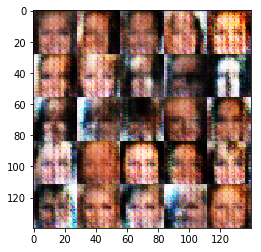

Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.6406
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.3198... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.4327... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6830


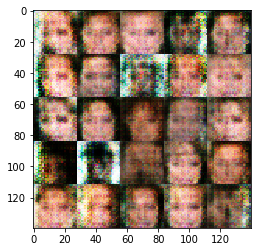

Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7116
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.3684... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.6291
Epoch 1/1... Discriminator Loss: 1.3476... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7251


Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.6997
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.6964
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.4237... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.8651
Epoch 1/1... Discriminator Loss: 0.9743... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.4128
Epoch 1/1... Discriminator Loss: 0.6559... Generator Loss: 1.0558


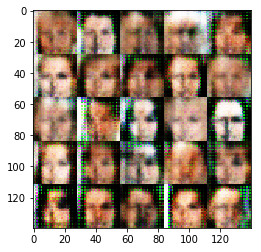

Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6695
Epoch 1/1... Discriminator Loss: 1.3853... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.6800
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7162
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.7090
Epoch 1/1... Discriminator Loss: 1.4446... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.7054


Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 0.5355... Generator Loss: 1.3243
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.6828
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7059
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 0.6355


Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.6680
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3821... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.6917
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3716... Generator Loss: 0.6741
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.6922


Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.6776
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.7008
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.6806
Epoch 1/1... Discriminator Loss: 1.4134... Generator Loss: 0.6591
Epoch 1/1... Discriminator Loss: 1.3846... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.3452... Generator Loss: 0.6934
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.6527
Epoch 1/1... Discriminator Loss: 1.3763... Generator Loss: 0.6845


Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6661
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.3889... Generator Loss: 0.6990


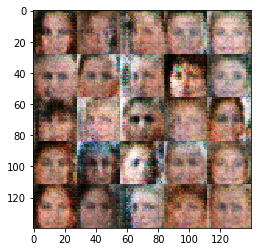

Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.7383
Epoch 1/1... Discriminator Loss: 1.6454... Generator Loss: 0.7735
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 1.3804... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.6749


Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.6669
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.6479
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.3800... Generator Loss: 0.6709
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.7020
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.6844


Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.3513... Generator Loss: 0.7210
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.6830
Epoch 1/1... Discriminator Loss: 1.2209... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.6284... Generator Loss: 1.3517
Epoch 1/1... Discriminator Loss: 1.3795... Generator Loss: 0.7369


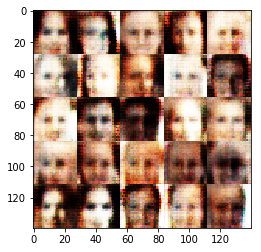

Epoch 1/1... Discriminator Loss: 1.3436... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.6528
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6769


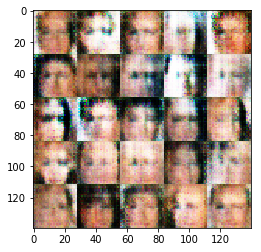

Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6898
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.3667... Generator Loss: 0.7155
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.3600... Generator Loss: 0.6945


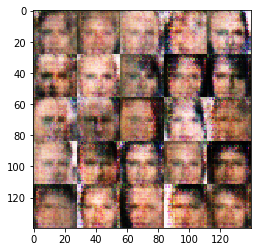

Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.0663... Generator Loss: 0.8413
Epoch 1/1... Discriminator Loss: 0.9286... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 0.1567... Generator Loss: 2.3010
Epoch 1/1... Discriminator Loss: 1.1791... Generator Loss: 0.9251


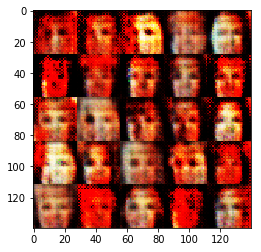

Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 1.4699
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.0888... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.0450... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.6598
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.7409
Epoch 1/1... Discriminator Loss: 0.9026... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.4219


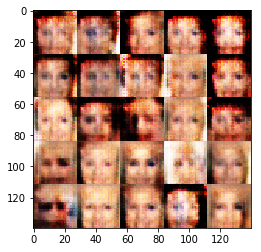

Epoch 1/1... Discriminator Loss: 1.2518... Generator Loss: 0.8531
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 0.7022
Epoch 1/1... Discriminator Loss: 1.4174... Generator Loss: 0.6584
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.3495... Generator Loss: 0.6857
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.6909
Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.6452
Epoch 1/1... Discriminator Loss: 1.9989... Generator Loss: 1.8748
Epoch 1/1... Discriminator Loss: 1.1032... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.6749


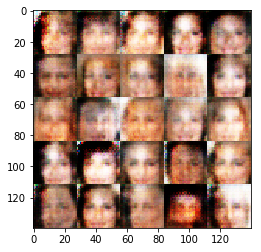

Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.3742... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.3461... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.7094


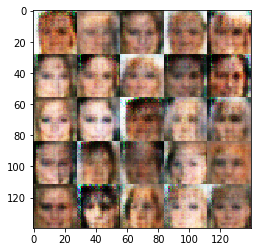

Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 1.0116
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.6883
Epoch 1/1... Discriminator Loss: 1.5052... Generator Loss: 1.3636
Epoch 1/1... Discriminator Loss: 0.1702... Generator Loss: 2.1629
Epoch 1/1... Discriminator Loss: 0.0731... Generator Loss: 3.0362


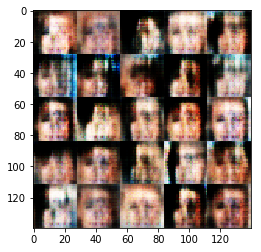

Epoch 1/1... Discriminator Loss: 1.2094... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7052
Epoch 1/1... Discriminator Loss: 1.3645... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.6339
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.6428
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.6870


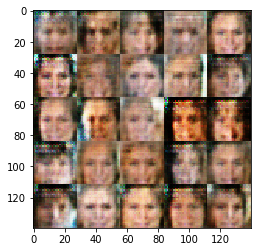

Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.6918
Epoch 1/1... Discriminator Loss: 1.3097... Generator Loss: 0.7082
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6283
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.7366


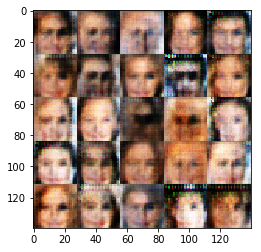

Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.6142
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.7104


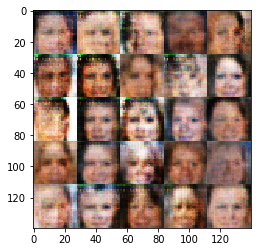

Epoch 1/1... Discriminator Loss: 1.3780... Generator Loss: 0.6496
Epoch 1/1... Discriminator Loss: 1.3050... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 0.9827... Generator Loss: 0.5983
Epoch 1/1... Discriminator Loss: 1.5546... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.2978... Generator Loss: 0.6710


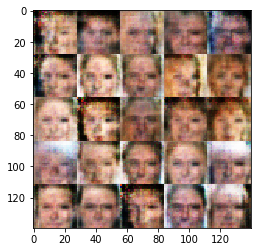

Epoch 1/1... Discriminator Loss: 0.8356... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.3236... Generator Loss: 0.6906
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.6302
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.6849
Epoch 1/1... Discriminator Loss: 1.3209... Generator Loss: 0.6853
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.6903


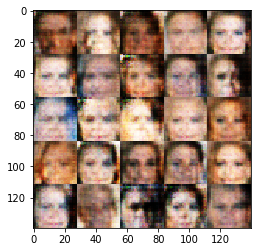

Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.6609
Epoch 1/1... Discriminator Loss: 1.3306... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3832... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.2853... Generator Loss: 0.6344
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.5897
Epoch 1/1... Discriminator Loss: 0.9226... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.6109
Epoch 1/1... Discriminator Loss: 0.3418... Generator Loss: 1.3753
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.6884


Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.3784... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.3137... Generator Loss: 0.7034
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.3725... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.7454


Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.3213... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.6834


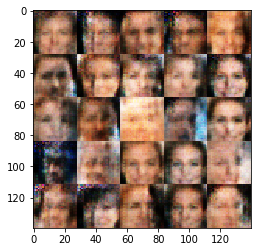

Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.6681
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.6781
Epoch 1/1... Discriminator Loss: 1.3397... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.6470
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.6885


Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.6884
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.6167
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6508
Epoch 1/1... Discriminator Loss: 1.3859... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.6799
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.6823


Epoch 1/1... Discriminator Loss: 1.3239... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.3583... Generator Loss: 0.6664
Epoch 1/1... Discriminator Loss: 1.3569... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.6728
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.3608... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.2121... Generator Loss: 0.8524


Epoch 1/1... Discriminator Loss: 1.5892... Generator Loss: 1.5361
Epoch 1/1... Discriminator Loss: 1.6368... Generator Loss: 0.5779
Epoch 1/1... Discriminator Loss: 1.2596... Generator Loss: 0.7067
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7160
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.0288... Generator Loss: 0.8604
Epoch 1/1... Discriminator Loss: 2.4271... Generator Loss: 0.1155


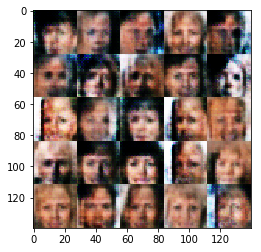

Epoch 1/1... Discriminator Loss: 1.6910... Generator Loss: 0.4997
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.3485... Generator Loss: 0.6635
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.3395... Generator Loss: 0.7025
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.6570


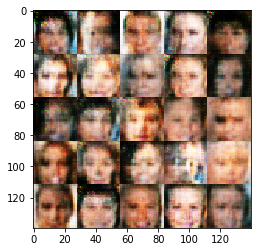

Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.4289... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.3644... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.2947... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.0118... Generator Loss: 0.5263
Epoch 1/1... Discriminator Loss: 0.9363... Generator Loss: 2.2324
Epoch 1/1... Discriminator Loss: 1.4087... Generator Loss: 0.5783


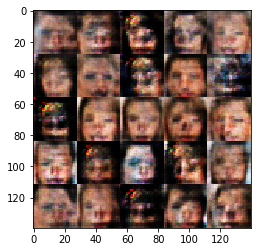

Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.6873
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.7142
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.6102
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 0.8745... Generator Loss: 1.0092
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.6089
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.6625
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.6437


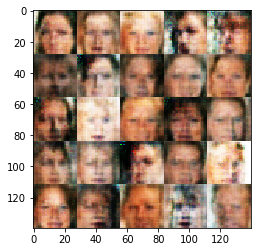

Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.4039... Generator Loss: 0.6085
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6267
Epoch 1/1... Discriminator Loss: 1.3678... Generator Loss: 0.6588
Epoch 1/1... Discriminator Loss: 1.3103... Generator Loss: 0.7017
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.6786
Epoch 1/1... Discriminator Loss: 1.3391... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.6994


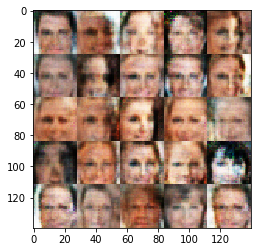

Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.3516... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.6542
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 0.1549... Generator Loss: 2.2372
Epoch 1/1... Discriminator Loss: 0.0767... Generator Loss: 3.3248


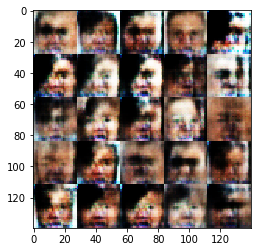

Epoch 1/1... Discriminator Loss: 3.3254... Generator Loss: 3.4090
Epoch 1/1... Discriminator Loss: 1.3015... Generator Loss: 0.8597
Epoch 1/1... Discriminator Loss: 1.5262... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3402... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.6796
Epoch 1/1... Discriminator Loss: 1.2737... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.8428
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.6437


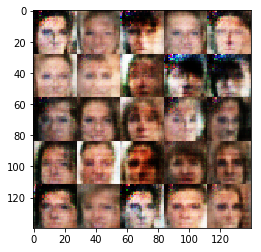

Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.6624
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.3656... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.6788
Epoch 1/1... Discriminator Loss: 1.3746... Generator Loss: 0.6848
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.3536... Generator Loss: 0.7190


Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.6916
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.6896
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.6592
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.6243
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.6785


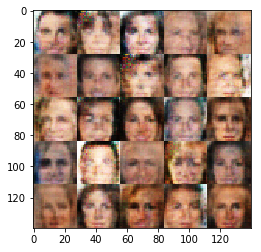

Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.3388... Generator Loss: 0.7109
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.5882
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.6580
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.6737


Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6706
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.4229... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.7212
Epoch 1/1... Discriminator Loss: 1.3777... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.7061
Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.7144
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7042


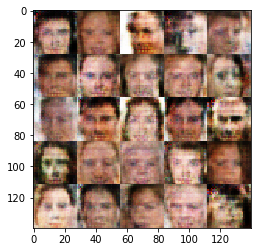

Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.6642
Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.3613... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.6631


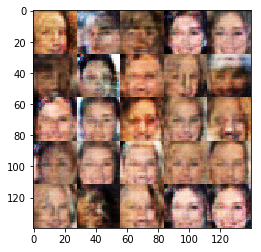

Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.5906
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 1.0819
Epoch 1/1... Discriminator Loss: 1.1425... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.2412... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.6340
Epoch 1/1... Discriminator Loss: 1.3140... Generator Loss: 0.4206
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.9216
Epoch 1/1... Discriminator Loss: 0.7530... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 1.5044... Generator Loss: 0.7277


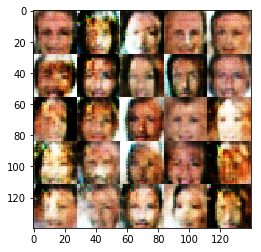

Epoch 1/1... Discriminator Loss: 1.3286... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.3727... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.7918
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.3387... Generator Loss: 0.7058
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.6481


Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 0.7901
Epoch 1/1... Discriminator Loss: 1.2389... Generator Loss: 0.8046
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.3775... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.6714
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.6206


Epoch 1/1... Discriminator Loss: 1.3180... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.2771... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.5831
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.3283... Generator Loss: 0.6015
Epoch 1/1... Discriminator Loss: 1.2943... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.2040... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.4733
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 0.3979


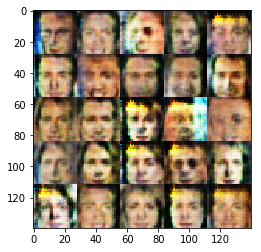

Epoch 1/1... Discriminator Loss: 1.5286... Generator Loss: 1.1026
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.6652
Epoch 1/1... Discriminator Loss: 1.3541... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.3323... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.3580... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.3433... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.4609... Generator Loss: 0.6105
Epoch 1/1... Discriminator Loss: 1.0432... Generator Loss: 0.5409


Epoch 1/1... Discriminator Loss: 0.2302... Generator Loss: 2.2018
Epoch 1/1... Discriminator Loss: 1.5039... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.4388... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.8340
Epoch 1/1... Discriminator Loss: 1.2998... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.3124... Generator Loss: 0.6903


Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.6444
Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.3205... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.1880... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.3688... Generator Loss: 0.5623
Epoch 1/1... Discriminator Loss: 1.3771... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.6837
Epoch 1/1... Discriminator Loss: 1.2823... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.2837... Generator Loss: 0.6669


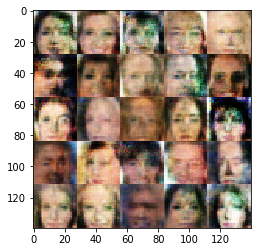

Epoch 1/1... Discriminator Loss: 1.3386... Generator Loss: 0.6238
Epoch 1/1... Discriminator Loss: 1.1979... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.5887
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.7679
Epoch 1/1... Discriminator Loss: 1.2409... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.6657
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.6380


Epoch 1/1... Discriminator Loss: 1.2391... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.2515... Generator Loss: 0.7713
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.7045


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.